In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dl_portfolio.data import impute_missing_risk_free, load_data, load_risk_free
from dl_portfolio.backtest import plot_perf, backtest_stats, get_target_vol_other_weights
import pickle
import os, sys
from sklearn.neighbors import KernelDensity
import seaborn as sns

# Some useful functions

In [2]:
def plot_weights(weights, savepath=None, x_step=2):
    strat_to_plot = ['hrp', 'aerp', 'ae_rp_c',  'aeaa', 'hcaa', 'nmfrp',  'nmf_rp_c', 'nmfaa']
    nrow, ncol = 2,4
    fig, axs = plt.subplots(nrow, ncol, figsize=(18, 5), sharex=True, sharey=True)
    LABELS = [str(d.date()) for d in weights['hrp'].index]
    NUM_COLORS = len(weights[strat_to_plot[0]].columns)
    cm = plt.get_cmap('gist_rainbow')
    row = -1
    for i, strat in enumerate(strat_to_plot):
        print(strat)
        col = i % ncol
        if col == 0:
            row = row + 1
        print(row, col)
        axs[row, col].set_prop_cycle(color=[cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)])

        """if strat == 'equal_class':
            data = pd.DataFrame(np.repeat(weights['equal_class'].values, len(LABELS), axis=0),
                                columns = weights['hrp'].columns,
                                index = weights['hrp'].index)
        else:
            data = weights[strat]"""

        for j, c in enumerate(list(weights[strat].columns)):
            axs[row, col].bar(LABELS, weights[strat][c], label=c, width=1, align='edge',
                              bottom=weights[strat].iloc[:, :j].sum(1))    
        axs[row, col].tick_params(axis='x', labelrotation=45)
        _ = axs[row, col].set_xticks(list(range(0, len(weights[strat].index), x_step)))

    plt.subplots_adjust(hspace = .1)
    plt.subplots_adjust(wspace = .05)

    if save:
        plt.savefig(savepath, bbox_inches='tight', transparent=True)

def plot_final_backtest_performance(returns, benchmark, save=False, save_path=None, hedge=False):
    plt.figure(figsize=(20,10))
    plt.plot((returns['equal'] + 1).cumprod() - 1,
             label="equal",
             color="royalblue"
            )
    plt.plot((returns['equal_class'] + 1).cumprod() - 1,
             label="equal_class",
             color="navy"
            )
    plt.plot((returns['markowitz'] + 1).cumprod() - 1, label="markowitz", color="darkslategray")
    plt.plot((returns['GMV_robust'] + 1).cumprod() - 1, label="GMV_robust", color="teal")
    
    plt.plot((returns['hrp'] + 1).cumprod() - 1, label="hrp", color="red")
    plt.plot((returns['aerp'] + 1).cumprod() - 1, label="aerp", color="lightcoral")
    if hedge:
        plt.plot((returns['aerp_hedge'] + 1).cumprod() - 1, label="aerp-hedge", color="lightcoral")
    plt.plot((returns['nmfrp'] + 1).cumprod() - 1, label="nmfrp", color="indianred")
    
    plt.plot((returns['hcaa'] + 1).cumprod() - 1, label="hcaa", color="orangered")
    plt.plot((returns['kmaa'] + 1).cumprod() - 1, label="kmaa", color="firebrick")
    plt.plot((returns['aeaa'] + 1).cumprod() - 1, label="aeaa", color="orange")
    if hedge:
        plt.plot((returns['aeaa_hedge'] + 1).cumprod() - 1, label="aeaa-hedge", color="orange")
    plt.plot((returns['nmfaa'] + 1).cumprod() - 1, label="nmfaa", color="darkorange")
    
    plt.plot((returns['ae_rp_c'] + 1).cumprod() - 1, label="aerc-w", color="chartreuse")
    if hedge:
        plt.plot((returns['ae_rp_c_hedge'] + 1).cumprod() - 1, label="aerc-w-hedge", color="chartreuse")
    plt.plot((returns['nmf_rp_c'] + 1).cumprod() - 1, label="nmfrc-w", color="green")


    plt.plot((benchmark.loc[returns.index, 'SP500'] * 0.05 / (benchmark.loc[returns.index, 'SP500'].std() * np.sqrt(252)) + 1).cumprod() - 1, 
             label='SP500',
             color='purple')

    plt.plot((benchmark.loc[returns.index, 'Russel2000'] * 0.05 / (benchmark.loc[returns.index, 'Russel2000'].std() * np.sqrt(252)) + 1).cumprod() - 1,
             label='Russel2000',
             color='fuchsia')
    plt.plot((benchmark.loc[returns.index, 'EuroStoxx50'] * 0.05 / (benchmark.loc[returns.index, 'EuroStoxx50'].std() * np.sqrt(252)) + 1).cumprod() - 1, 
             label='EuroStoxx50',
             color='violet')
    
    plt.plot(np.cumprod(returns['ae_rp_c'] + 1) - np.cumprod(returns['ae_rp_c'] + 1), linestyle= '--', c="lightgrey")
    if save:
        plt.savefig(save_path, bbox_inches='tight', transparent=True)
    else:
        plt.legend()
        plt.show()
        
def load_all_backtest_result(ae_dir, nmf_dir, markowitz_dir, dataset):
    # Load Market budget
    if dataset == 'dataset1':
        market_budget = pd.read_csv('data/dataset1/market_budget_dataset1.csv', index_col=0)
        cryptos = ['BTC', 'DASH', 'ETH', 'LTC', 'XRP']
        market_budget = pd.concat([market_budget, pd.DataFrame(np.array([['crypto', 1]] * len(cryptos)),
                                                               index=cryptos,
                                                               columns=market_budget.columns)])
        # market_budget = market_budget.drop('CRIX')
        market_budget['rc'] = market_budget['rc'].astype(int)
    elif dataset == 'dataset2':
        market_budget = pd.read_csv('data/dataset2/market_budget_dataset2.csv', index_col=0)
        market_budget['rc'] = market_budget['rc'].astype(int)
    else:
        raise NotImplementedError()
        
    # Load markowitz and robust M results
    GMV_robust_weights = pd.read_csv(f"{markowitz_dir}/weights_GMV_robust.csv", index_col = 0)
    GMV_robust_weights.index = pd.to_datetime(GMV_robust_weights.index)
    markowitz_weights = pd.read_csv(f"{markowitz_dir}/weights_MeanVar_long.csv", index_col = 0)
    markowitz_weights.index = pd.to_datetime(markowitz_weights.index)
    
    # Leverage
    leverage = pd.read_csv(f'{ae_dir}/leverage.csv', index_col = 0)
    pyrobustm, l = get_target_vol_other_weights(f"GMV_robust_{dataset}")
    leverage["GMV_robust"] = l['other']
    pyrobustm.columns = ['GMV_robust']
    markowitz, l = get_target_vol_other_weights(f"MeanVar_{dataset}")
    leverage["markowitz"] = l['other']
    markowitz.columns = ['markowitz']
    print("markowitz", leverage["markowitz"])
    print("GMV_robust", leverage["GMV_robust"])
    
    port_weights = pickle.load(open(f'{ae_dir}/portfolios_weights.p', 'rb'))
    nmf_port_weights = pickle.load(open(f'{nmf_dir}/portfolios_weights.p', 'rb'))
    for k in nmf_port_weights.keys():
        key = k.replace("ae", "nmf")
        port_weights[key] = nmf_port_weights[k]
    port_weights["markowitz"] = markowitz_weights.loc[port_weights["ae_rp_c"].index]
    port_weights["GMV_robust"] = GMV_robust_weights.loc[port_weights["ae_rp_c"].index]


    ann_perf = pd.read_csv(f'{ae_dir}/portfolios_returns.csv', index_col = 0)
    ann_perf.index = pd.to_datetime(ann_perf.index)
    ann_perf['GMV_robust'] = pyrobustm['GMV_robust']
    ann_perf['markowitz'] = markowitz['markowitz']

    nmf_perf = pd.read_csv(f'{nmf_dir}/portfolios_returns.csv', index_col = 0)
    nmf_perf.index = pd.to_datetime(nmf_perf.index)
    nmf_perf.columns = [c.replace('ae', 'nmf') for c in nmf_perf.columns]
    common_cols = [c for c in nmf_perf.columns if "nmf" not in c]
    nmf_perf.drop(common_cols, 1, inplace = True)
    
    ann_perf = pd.concat([ann_perf, nmf_perf], 1)    
    stats = backtest_stats(ann_perf, port_weights, period=252, market_budget=market_budget)
    
    return ann_perf, port_weights, leverage, stats

# Save directory

In [3]:
SAVE=True
save=SAVE
savedir = "paper_result_update"
if save:
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
   

# Load backtest result

In [4]:
perf_ae_dir_1 = "./performance/test_final_models/ae/dataset1_20230220_110629"
perf_nmf_dir_1 = "./performance/test_final_models/nmf/dataset1_20230220_110418"
markowitz_dir1 = "final_models/run_7_global_bond_dl_portfolio_20220122_151211"
perf_ae_dir_2 = "./performance/test_final_models/ae/dataset2_20230220_111557"
perf_nmf_dir_2 = "./performance/test_final_models/nmf/dataset2_20230220_110803"
markowitz_dir2 = "final_models/run_6_multiasset_traditional_dl_portfolio_20211206_173539"

perf1, port_weights1, leverage1, stats1 = load_all_backtest_result(perf_ae_dir_1, 
                                                                   perf_nmf_dir_1,
                                                                   markowitz_dir1,
                                                                   "dataset1")
dates1 = perf1.index

perf2, port_weights2, leverage2, stats2 = load_all_backtest_result(perf_ae_dir_2, 
                                                                   perf_nmf_dir_2,
                                                                   markowitz_dir2,
                                                                   "dataset2")
dates2 = perf2.index

/Users/brunospilak/miniconda3/envs/embedding-portfolio/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/brunospilak/miniconda3/envs/embedding-portfolio/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
[DL-Portfolio-Logger:backtest.py:158] - [94258] - 2023-02-21 11:42:41,991 - DEBUG - Formatting table


markowitz 0     0.119787
1     0.079694
2     0.095625
3     0.078323
4     0.153641
5     0.193092
6     0.242388
7     0.383116
8     0.086512
9     0.062279
10    0.067362
11    0.067014
12    0.043101
13    0.030770
14    0.040032
15    0.039001
16    0.053743
17    0.040842
18    0.032788
19    0.036345
20    0.041540
21    0.053295
Name: markowitz, dtype: float64
GMV_robust 0     1.934401
1     1.786142
2     1.718737
3     0.638728
4     0.466225
5     0.698802
6     1.068184
7     2.150131
8     1.487956
9     1.828749
10    1.842191
11    2.018101
12    1.787150
13    1.777743
14    1.718330
15    1.478617
16    1.510693
17    1.425477
18    1.500509
19    1.419806
20    1.472168
21    1.496386
Name: GMV_robust, dtype: float64


/Users/brunospilak/miniconda3/envs/embedding-portfolio/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/brunospilak/miniconda3/envs/embedding-portfolio/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
[DL-Portfolio-Logger:backtest.py:158] - [94258] - 2023-02-21 11:44:04,833 - DEBUG - Formatting table


markowitz 0      0.507944
1      0.410037
2      0.701182
3      0.425736
4      0.428510
         ...   
172    0.214882
173    0.276900
174    0.694307
175    0.378432
176    0.585427
Name: markowitz, Length: 177, dtype: float64
GMV_robust 0      4.480348
1      3.712479
2      3.442375
3      3.612307
4      4.334365
         ...   
172    3.944569
173    3.886549
174    4.806849
175    5.487111
176    6.391672
Name: GMV_robust, Length: 177, dtype: float64


In [5]:
benchmark, _ = load_data(dataset='dataset2')
benchmark = benchmark.pct_change().dropna()
benchmark1 = benchmark.loc[dates1]

risk_free = load_risk_free()
risk_free = risk_free.reindex(benchmark.index)
risk_free = impute_missing_risk_free(risk_free)

In [6]:
benchmark, _ = load_data(dataset='dataset2')
benchmark = benchmark.pct_change().dropna()

benchmark1 = benchmark.loc[dates1]
leverage1 = 0.05 / (benchmark1.std() * np.sqrt(252))
lev_cost = np.repeat(risk_free.loc[benchmark1.index].values,
                     len(leverage1), axis=-1) * (1 - leverage1.values.reshape(1,-1))
benchmark1 = benchmark1*leverage1 + lev_cost

In [7]:
benchmark2 = benchmark.loc[dates2]
leverage2 = 0.05 / (benchmark2.std() * np.sqrt(252))
lev_cost = np.repeat(risk_free.loc[benchmark2.index].values, 
                     len(leverage2), axis=-1) * (1 - leverage2.values.reshape(1,-1))
benchmark2 = benchmark2*leverage2 + lev_cost

# Dataset 1

## Backtest performance

In [8]:
perf1.head()

,equal,equal_class,hrp,hcaa,aerp,aeerc,ae_rp_c,aeaa,kmaa,GMV_robust,markowitz,nmfrp,nmferc,nmf_rp_c,nmfaa
2019-12-13,0.002312,0.002338,-0.007090,-0.001396,-0.004330,-0.000121,0.000454,0.000807,0.000413,0.010736,0.000562,-0.004433,-0.000750,-0.000165,0.000660
2019-12-16,-0.005291,-0.005661,0.001221,-0.002636,0.000525,0.000281,0.000972,-0.005809,-0.006265,0.005849,-0.003826,0.000419,0.000225,0.000474,-0.005833
2019-12-17,-0.007867,-0.007995,-0.002149,-0.007545,-0.001813,-0.005266,-0.005142,-0.008195,-0.007434,0.000116,-0.003748,-0.001838,-0.005878,-0.005328,-0.008393
2019-12-18,0.009181,0.009199,-0.001970,0.008947,-0.001871,0.000846,0.000219,0.009302,0.009509,-0.002305,0.010845,-0.001847,0.000975,0.000354,0.009378
2019-12-19,-0.003768,-0.003760,-0.002065,-0.002311,-0.002194,-0.003006,-0.002676,-0.003986,-0.003750,0.000412,-0.002944,-0.002132,-0.002920,-0.002740,-0.003981


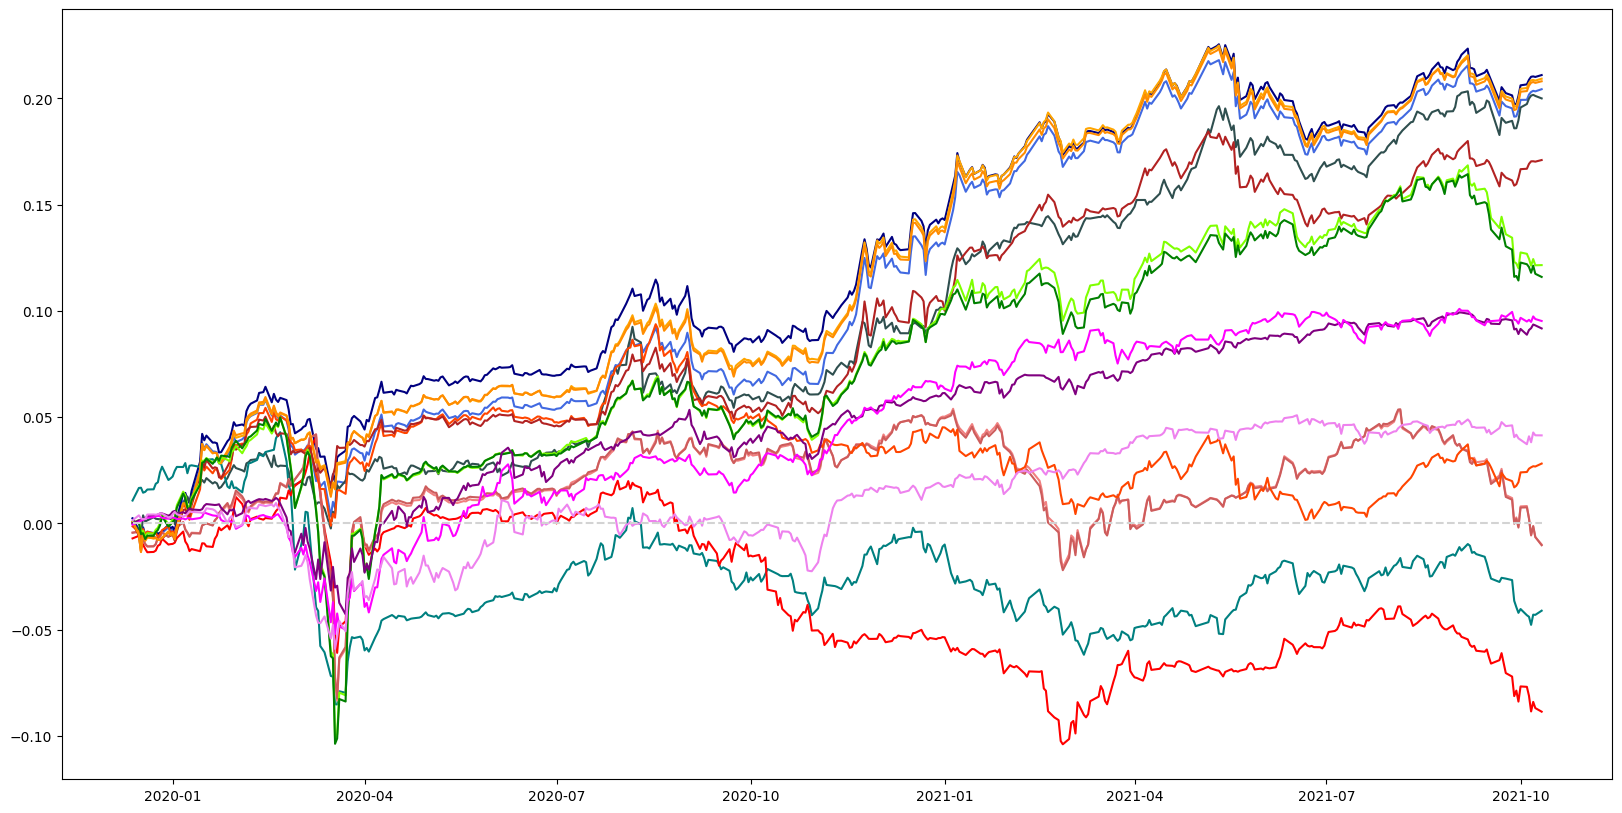

In [9]:
save = SAVE
save_path = f"{savedir}/performance_all_dataset1.png"
plot_final_backtest_performance(perf1, benchmark1, save=save, save_path=save_path)


## Backtest stats

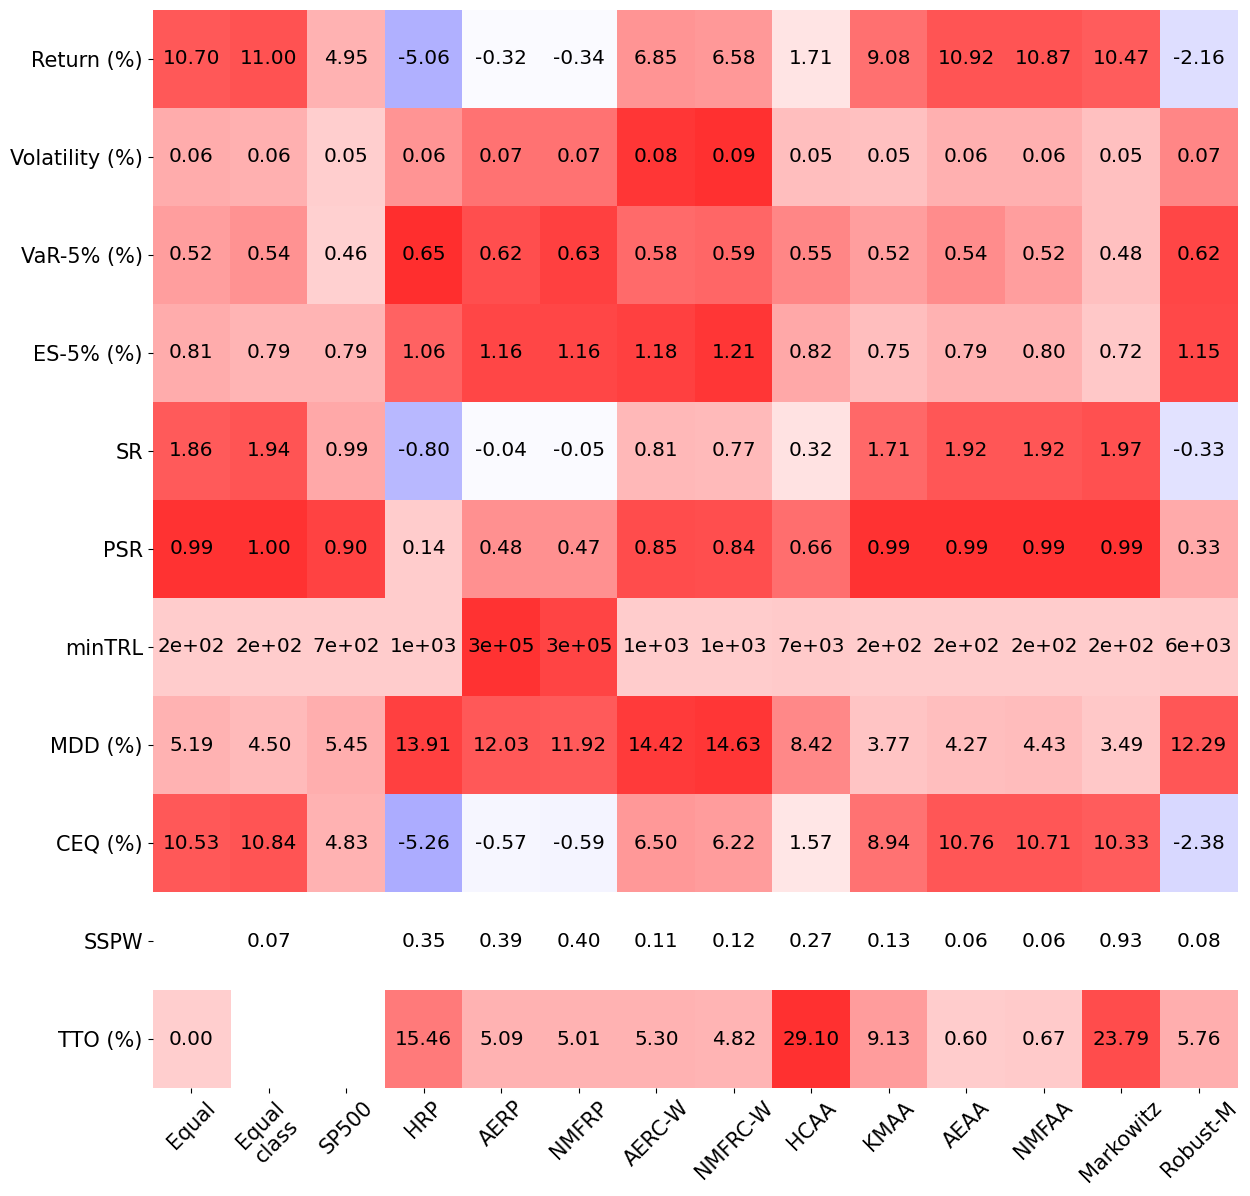

In [10]:
save = SAVE
ORDER = ["equal", "equal_class", "SP500", "hrp", "aerp", "nmfrp", "ae_rp_c", 
            "nmf_rp_c", "hcaa", "kmaa", "aeaa", "nmfaa", "markowitz", "GMV_robust"]

XTICKLABELS = ["Equal", "Equal\nclass", "SP500", "HRP", "AERP", "NMFRP", 
               "AERC-W", "NMFRC-W", "HCAA", "KMAA", "AEAA", "NMFAA",
               "Markowitz", "Robust-M"]
stats1.loc[['SP500', 'Russel2000', 'EuroStoxx50'], 'TTO'] = np.nan
pstats = stats1.drop(["Russel2000", "EuroStoxx50", "aeerc", "nmferc"])
pstats = pstats.loc[ORDER, :]


metrics = [c for c in list(pstats.columns) if c not in ['CR', 'Skewness', 'Excess kurtosis']]
fig, axs = plt.subplots(len(metrics), 1, figsize = (14,14), sharex = True)
i = 0
for i, c in enumerate(metrics):
    if c == "Return":
        cmap = "bwr"
    elif c == "Volatility":
        cmap="bwr"
        
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        yticklabel = c + ' (%)'
    else:
        yticklabel = c
        
    temp = pstats.loc[:, [c]].T
    
    min_ = min(temp.loc[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp.loc[c]) - np.std(temp.loc[c])
    sns.heatmap(temp,
                cmap='bwr', 
                center=center, 
                vmin=min(temp.loc[c]) - np.std(temp.loc[c]),
                vmax=max(temp.loc[c]) + np.std(temp.loc[c]),
                annot=True,
                fmt='.2f' if c != "minTRL" else '.1g',
                annot_kws={'color': 'black', 'size': 'x-large', 'ha': 'center'},
                yticklabels = [yticklabel],
                xticklabels = XTICKLABELS,
                cbar=False,
                ax=axs[i])    
    axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    axs[i].tick_params(axis='x', labelrotation = 45,  labelsize=15)

plt.subplots_adjust(hspace = .000)

if save:
    plt.savefig(f'{savedir}/stats_heatmap_dataset1.png', bbox_inches='tight', transparent=True)

In [23]:
def ceq(returns, gamma: float = 1.0, period: int = 1):
    """
    See Raffinot paper or DeMiguel et al. [2009]
    :param perf: returns
    :param gamma: risk aversion
    :param risk_free: risk free rate
    :return:
    """

    risk_free = load_risk_free()
    risk_free = risk_free.reindex(returns.index)
    risk_free = impute_missing_risk_free(risk_free)
    
    excess_ret = returns - risk_free["risk_free"]
    return (
        excess_ret.mean() * period
    ) - gamma / 2 * excess_ret.var() * period


In [24]:
for m in perf2:
    print(m, ceq(perf2[m], period=250) *100)

equal 1.8533912925992566
equal_class 2.883454644280961
hrp -1.7409107010335163
hcaa 1.760819225095644
aerp -1.4824331214027582
aeerc 1.9511008945077095
ae_rp_c 2.008992016699628
aeaa 1.715777310394041
kmaa 1.967289169957979
GMV_robust 0.1671095689707668
markowitz 2.6718015554898344
nmfrp -1.4455867051082927
nmferc 1.9826874455702688
nmf_rp_c 1.977693157547047
nmfaa 1.6840416246474679


## Weights

hrp
0 0
aerp
0 1
ae_rp_c
0 2
aeaa
0 3
hcaa
1 0
nmfrp
1 1
nmf_rp_c
1 2
nmfaa
1 3


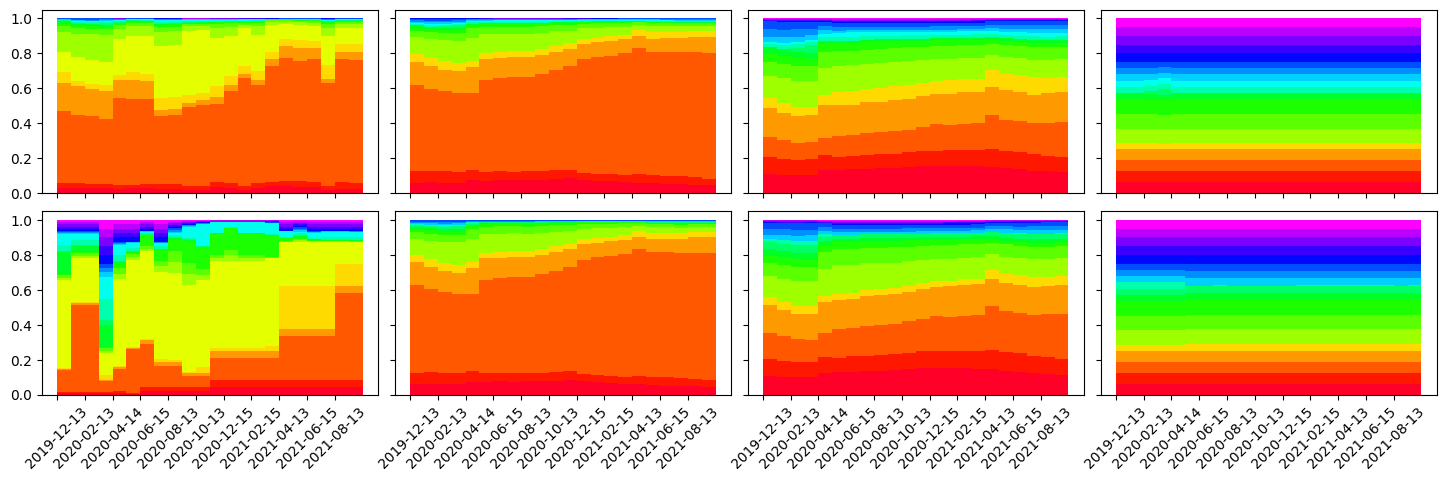

In [11]:
save=SAVE
weights = port_weights1.copy()        
if save:
    savepath = f'{savedir}/weights_barplot_dataset1.png'
else:
    savepath = None
plot_weights(weights, savepath=savepath)

# Dataset 2
## Backtest performance

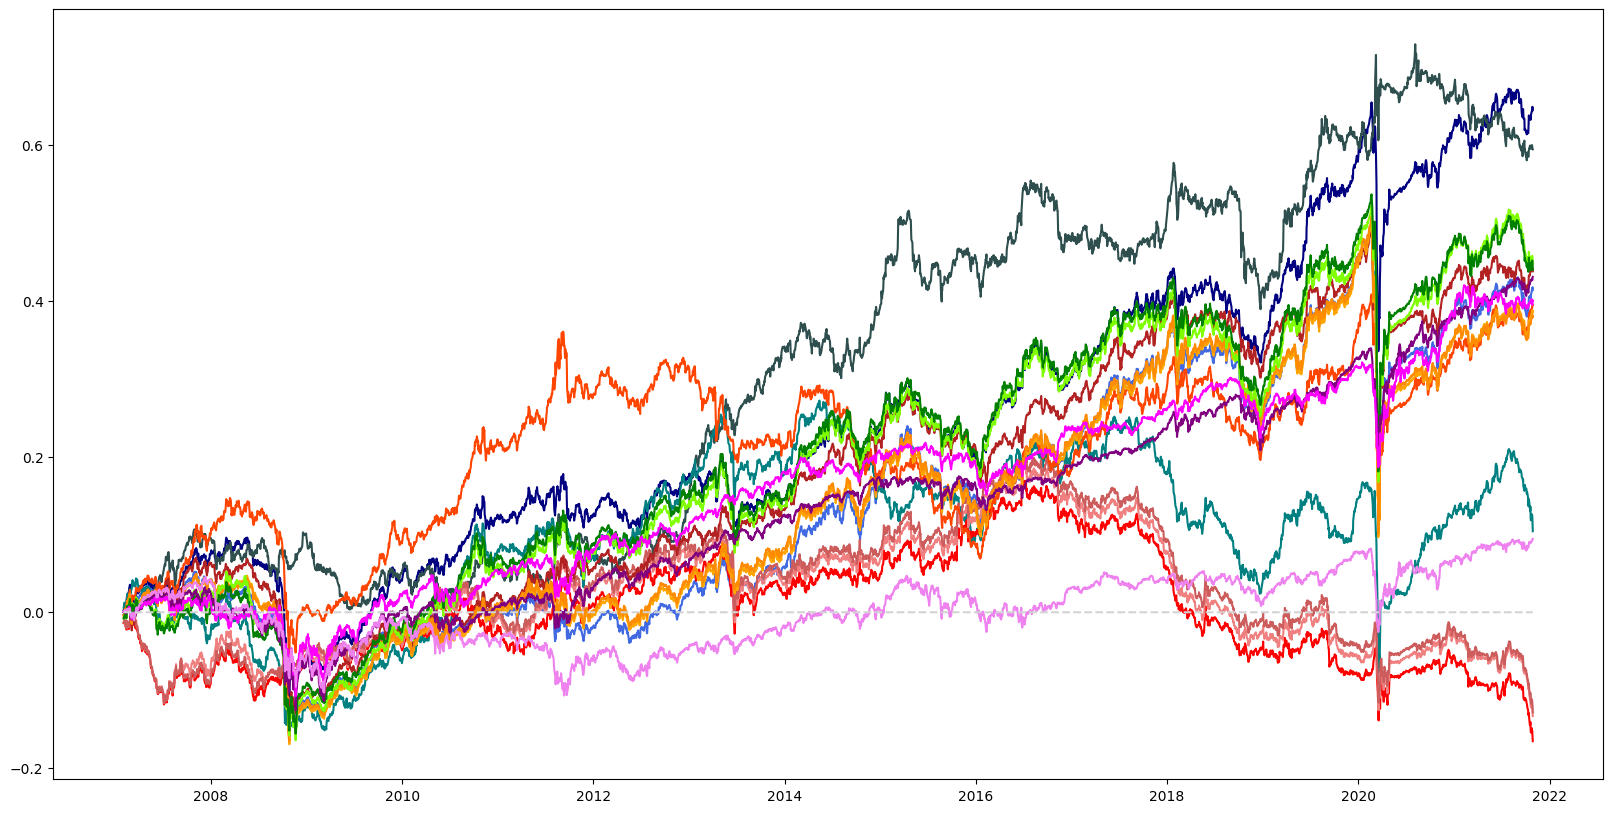

In [12]:
save = SAVE
save_path = f"{savedir}/performance_all_dataset2.png"
plot_final_backtest_performance(perf2, benchmark2, save=save, save_path=save_path)


## Backtest stats

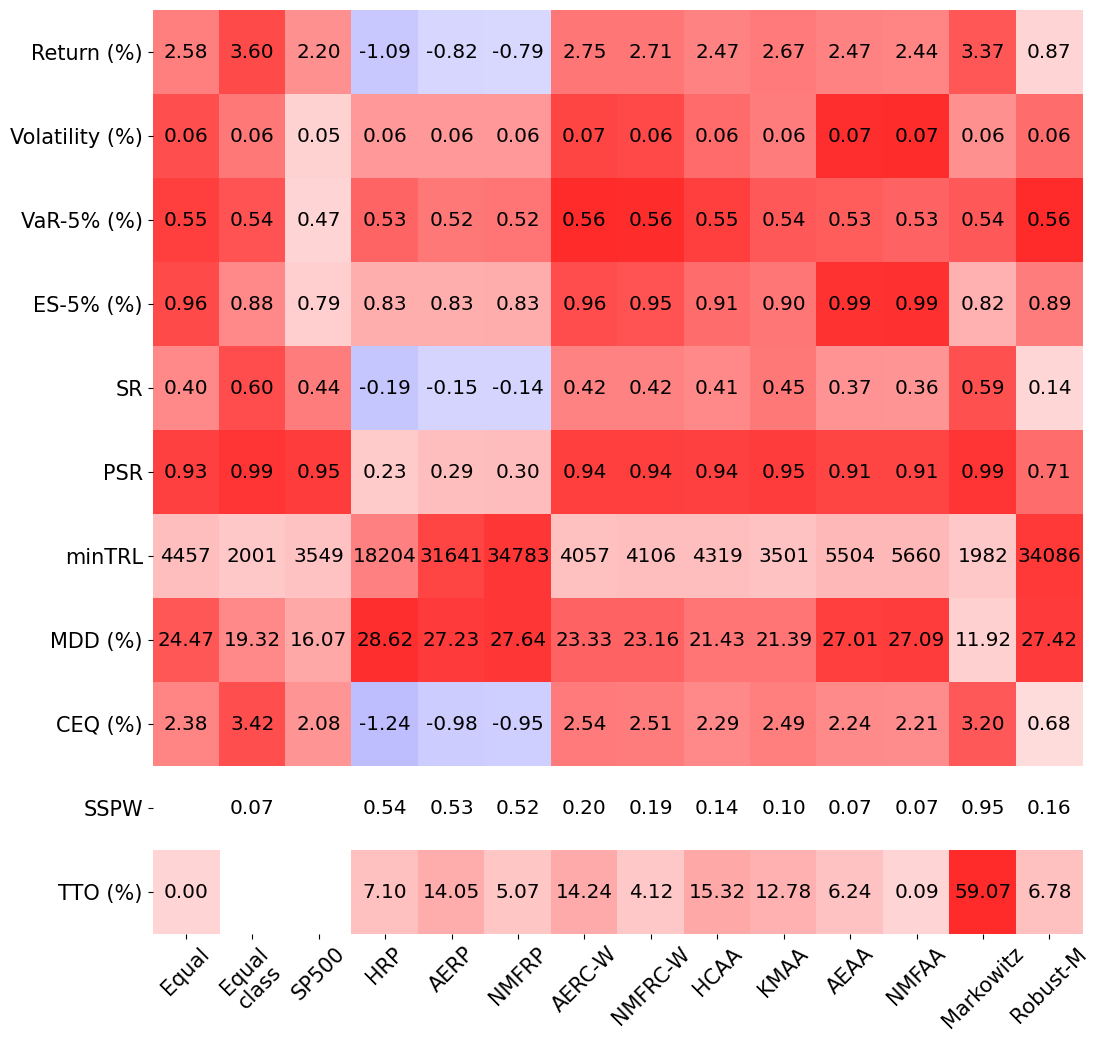

In [13]:
save = SAVE
stats2.loc[['SP500', 'Russel2000', 'EuroStoxx50'], 'TTO'] = np.nan
pstats = stats2.drop(["Russel2000", "EuroStoxx50", "aeerc", "nmferc"])
pstats = pstats.loc[ORDER, :]


metrics = [c for c in list(pstats.columns) if c not in ['CR', 'Skewness', 'Excess kurtosis']]
fig, axs = plt.subplots(len(metrics), 1, figsize = (12,12), sharex = True)
i = 0
for i, c in enumerate(metrics):
    if c == "Return":
        cmap = "bwr"
    elif c == "Volatility":
        cmap="bwr"
        
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        yticklabel = c + ' (%)'
    else:
        yticklabel = c
        
    temp = pstats.loc[:, [c]].T
    min_ = min(temp.loc[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp.loc[c]) - np.std(temp.loc[c])
    sns.heatmap(temp,
                cmap='bwr', 
                center=center, 
                vmin=min(temp.loc[c]) - np.std(temp.loc[c]),
                vmax=max(temp.loc[c]) + np.std(temp.loc[c]),
                annot=True,
                fmt='.2f' if c != "minTRL" else '.0f',
                annot_kws={'color': 'black', 'size': 'x-large', 'ha': 'center'},
                yticklabels = [yticklabel],
                xticklabels = XTICKLABELS,
                cbar=False,
                ax=axs[i])    
    axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    axs[i].tick_params(axis='x', labelrotation = 45,  labelsize=15)

plt.subplots_adjust(hspace = .000)

if save:
    plt.savefig(f'{savedir}/stats_heatmap_dataset2.png', bbox_inches='tight', transparent=True)
   
    

## Weights

hrp
0 0
aerp
0 1
ae_rp_c
0 2
aeaa
0 3
hcaa
1 0
nmfrp
1 1
nmf_rp_c
1 2
nmfaa
1 3


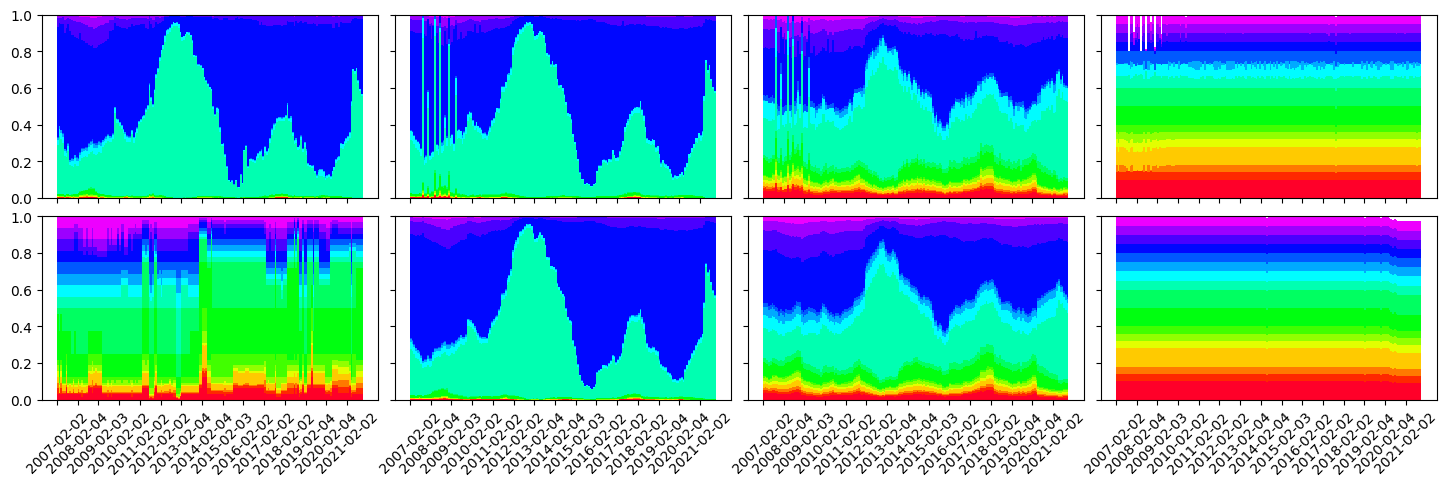

In [14]:
save=SAVE
weights = port_weights2.copy()        
if save:
    savepath = f'{savedir}/weights_barplot_dataset2.png'
else:
    savepath = None
plot_weights(weights, savepath=savepath, x_step=12)

In [64]:
pstatsf = pstats.drop(["Volatility", "Skewness", "Excess kurtosis", "CR"], axis=1)
pstatsf = pstatsf.astype(float).round(2)
pstatsf.index = XTICKLABELS
pstatsf.columns = ['Return (\%)', 'VaR-5% (\%)', 'ES-5% (\%)', 'SR', 'PSR', 'minTRL', 'MDD (\%)', 'CEQ (\%)', 'SSPW (\%)', 'TTO (\%)']
pstatsf["minTRL"] = pstatsf["minTRL"].round(0).astype(int)
pstatsf.to_csv("stats2.csv")

In [63]:
perf2.mean() * 252


equal          0.025845
equal_class    0.035954
hrp           -0.010856
hcaa           0.024726
aerp          -0.008246
aeerc          0.026894
ae_rp_c        0.027482
aeaa           0.024691
kmaa           0.026690
GMV_robust     0.008659
markowitz      0.033679
nmfrp         -0.007872
nmferc         0.027191
nmf_rp_c       0.027142
nmfaa          0.024380
dtype: float64

In [48]:
pstatsf["minTRL"].round(2)

equal           4457.080078
equal_class     2001.390015
SP500           3549.189941
hrp            18204.330078
aerp           31641.060547
nmfrp          34782.710938
ae_rp_c         4056.590088
nmf_rp_c        4106.029785
hcaa            4318.859863
kmaa            3500.620117
aeaa            5504.009766
nmfaa           5659.540039
markowitz       1981.910034
GMV_robust     34085.769531
Name: minTRL, dtype: float32